In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf


#Modélisation

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [1]:
import os
root_dir = r"C:\Users\Admin8\Downloads\archiveim\Covid-19_Radiography_Dataset"
for folder, subfolders, files in os.walk(root_dir):
    print(folder)
    print(subfolders)
    print(files)

C:\Users\Admin8\Downloads\archiveim\Covid-19_Radiography_Dataset
['COVID-19_Radiography_Dataset']
[]
C:\Users\Admin8\Downloads\archiveim\Covid-19_Radiography_Dataset\COVID-19_Radiography_Dataset
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
[]
C:\Users\Admin8\Downloads\archiveim\Covid-19_Radiography_Dataset\COVID-19_Radiography_Dataset\COVID
[]
['COVID-1.png', 'COVID-10.png', 'COVID-100.png', 'COVID-1000.png', 'COVID-1001.png', 'COVID-1002.png', 'COVID-1003.png', 'COVID-1004.png', 'COVID-1005.png', 'COVID-1006.png', 'COVID-1007.png', 'COVID-1008.png', 'COVID-1009.png', 'COVID-101.png', 'COVID-1010.png', 'COVID-1011.png', 'COVID-1012.png', 'COVID-1013.png', 'COVID-1014.png', 'COVID-1015.png', 'COVID-1016.png', 'COVID-1017.png', 'COVID-1018.png', 'COVID-1019.png', 'COVID-102.png', 'COVID-1020.png', 'COVID-1021.png', 'COVID-1022.png', 'COVID-1023.png', 'COVID-1024.png', 'COVID-1025.png', 'COVID-1026.png', 'COVID-1027.png', 'COVID-1028.png', 'COVID-1029.png', 'COVID-103.png', 'COV

In [3]:
#viral pneumonia = pneumionie viral
#lung opacity = opacité pulmonare

levels = ['Normal', 'COVID', 'Lung_Opacity', 'ViralPneumonia']
path = 'C:\Users\Admin8\Downloads\archiveim\Covid-19_Radiography_Dataset'
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

# dataframe avec une colonne avec le file de chaque image et une autre avec le label associé
data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-1.png,Normal,C:/Users/admin/Documents/Kaggle_ChestXrayDatas...
1,Normal/images/Normal-10.png,Normal,C:/Users/admin/Documents/Kaggle_ChestXrayDatas...
2,Normal/images/Normal-100.png,Normal,C:/Users/admin/Documents/Kaggle_ChestXrayDatas...
3,Normal/images/Normal-1000.png,Normal,C:/Users/admin/Documents/Kaggle_ChestXrayDatas...
4,Normal/images/Normal-10000.png,Normal,C:/Users/admin/Documents/Kaggle_ChestXrayDatas...


In [4]:
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        print(folder)

COVID
Lung_Opacity
Normal
ViralPneumonia


# Image Display

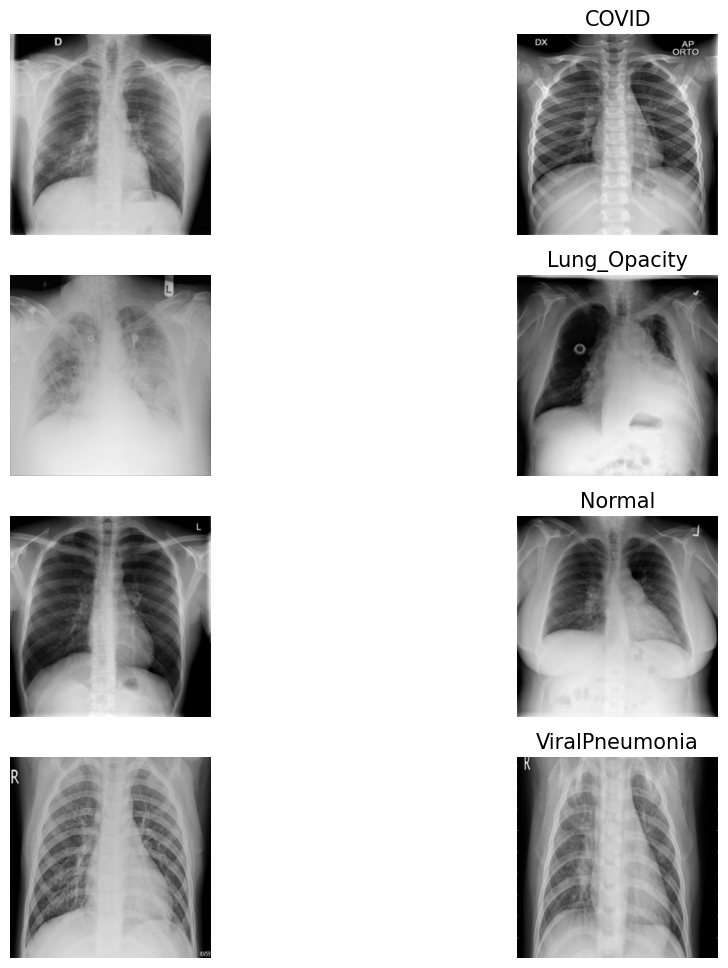

In [5]:
#visualization of 3 images per label
n_samples = 2

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

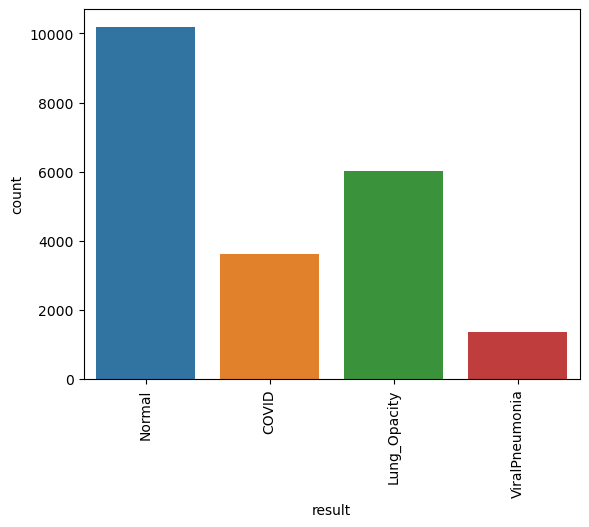

In [6]:
#View labels distribution to ascertain how to balance the data for testing and training
sx = sns.countplot(data=data, x='result')
sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)
plt.show()

In [7]:
#Print the observations
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))
print('Lung Opacity : ', list(data['result']).count('Lung_Opacity'))
print('Viral Pneumonia : ', list(data['result']).count('Viral Pneumonia'))
#10192 pictures are no

Normal :  10192
Covid :  3616
Lung Opacity :  6012
Viral Pneumonia :  0


In [8]:
#calculates the percentage distribution of the different categories in the 'result' column of the DataFrame 'data'

round(data['result'].value_counts() / data.shape[0] * 100,2)
#48% of images are normal

Normal            48.15
Lung_Opacity      28.41
COVID             17.08
ViralPneumonia     6.35
Name: result, dtype: float64

In [9]:
#to load images with pixels and reshape
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

100%|██████████| 21165/21165 [06:33<00:00, 53.77it/s]


In [52]:
#one variable with images and the other with labels
#images of dimension 64*64
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'ViralPneumonia' : 3})

print(pixel_img.shape, label_img.shape)
#we have 211165 images of dimensions 64*64



(21165, 64, 64, 1) (21165,)


# Create the training and testing sets

In [12]:
#20% of data in validation sample
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#16932 images dans le train et 4233 dans le test

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932,)
(4233,)


In [14]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)
#% distribution of labels in the training sample 

0    48.16
2    28.40
1    17.09
3     6.35
Name: result, dtype: float64

# for the CNN

In [15]:
#for the convolutional models we keep the images in dimension 64*64

#20% of data in validation sample
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

input_shape = (X_train.shape[1],X_train.shape[2],1)

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932, 4)
(4233, 4)


In [ ]:
model.add(Conv2D(32,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

In [21]:
#Build the CNN Architecture model

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

model=Sequential()

model.add(Conv2D(32, (3, 3), data.shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2663570416.py, line 9)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), data.shape=input_shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (741125155.py, line 7)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 29, 29, 32)        0         
                                                      

In [30]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

datagen.fit(X_train)

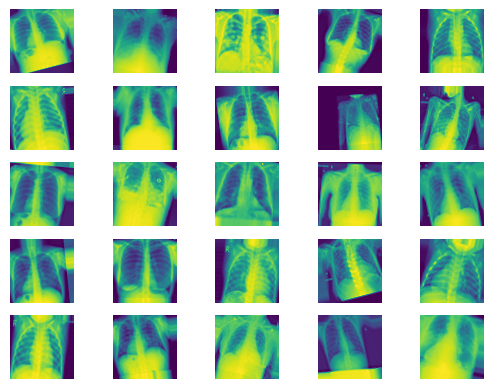

In [31]:
#visualization of new images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=25):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    plt.show()
    break

In [36]:
# Define the last layer with 4 units
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=len(X_train) // 128, epochs=50,
                    validation_data=(X_test, y_test))


Epoch 1/50
132/132 [==============================] - 96s 712ms/step - loss: 1.3395 - accuracy: 0.3772 - val_loss: 1.2099 - val_accuracy: 0.6799
Epoch 2/50
132/132 [==============================] - 84s 637ms/step - loss: 1.1680 - accuracy: 0.6447 - val_loss: 1.0958 - val_accuracy: 0.6702
Epoch 3/50
132/132 [==============================] - 89s 676ms/step - loss: 1.0684 - accuracy: 0.6613 - val_loss: 1.0114 - val_accuracy: 0.6823
Epoch 4/50
132/132 [==============================] - 83s 628ms/step - loss: 0.9961 - accuracy: 0.6685 - val_loss: 0.9305 - val_accuracy: 0.7012
Epoch 5/50
132/132 [==============================] - 82s 623ms/step - loss: 0.9448 - accuracy: 0.6812 - val_loss: 0.9013 - val_accuracy: 0.6934
Epoch 6/50
132/132 [==============================] - 83s 627ms/step - loss: 0.9099 - accuracy: 0.6823 - val_loss: 0.8481 - val_accuracy: 0.7075
Epoch 7/50
132/132 [==============================] - 84s 632ms/step - loss: 0.8733 - accuracy: 0.6910 - val_loss: 0.8450 - val_ac

In [38]:
loss, accuracy = model.evaluate(X_test, y_test)

133/133 [==============================] - 3s 24ms/step - loss: 0.5208 - accuracy: 0.8032


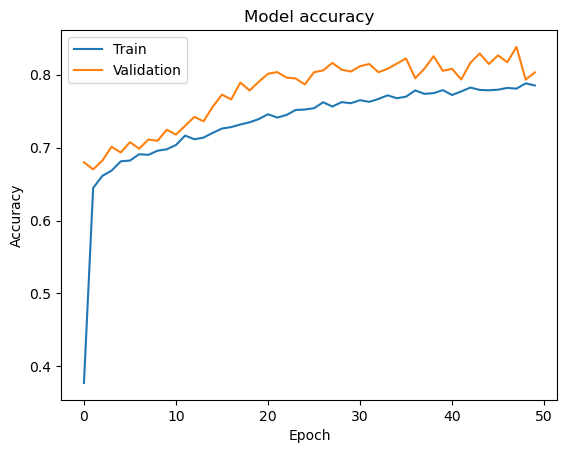

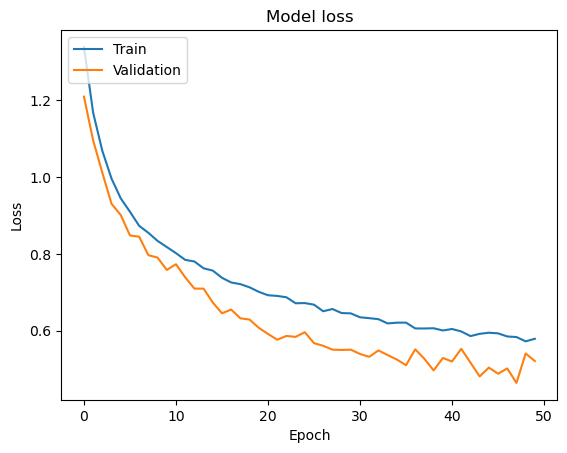

In [82]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [93]:
import joblib

# Assuming you have trained a model named 'model'
joblib.dump(model, 'model.joblib')



['model.joblib']